## Simple baseline with Landsat Cubes — ResNet18 + Binary Cross Entropy [0.26424]

To demonstrate the potential of other data such as Landsat cubes, we provide a
straightforward baseline that is baseline on a modified ResNet18 and Binary
Cross Entropy but still ranks highly on the leaderboard. The model itself should
learn the relationship between the location [R, G, B, NIR, SWIR1, and SWIR2]
value at a given location and its species composition.

Considering the significant extent for enhancing performance of this baseline,
we encourage you to experiment with various techniques, architectures, losses,
etc.

#### **Have Fun!**

In [1]:
import os
import torch
import tqdm
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_recall_fscore_support

## Data description

Satellite time series data includes over 20 years of Landsat satellite imagery
extracted from [Ecodatacube](https://stac.ecodatacube.eu/). The data was
acquired through the Landsat satellite program and pre-processed by Ecodatacube
to produce raster files scaled to the entire European continent and projected
into a unique CRS.

Since the original rasters require a high amount of disk space, we extracted the
data points from each spectral band corresponding to all PA and PO locations
(i.e., GPS coordinates) and aggregated them in (i) CSV files and (ii) data cubes
as tensor objects. Each data point corresponds to the mean value of Landsat's
observations at the given location for three months before the given time; e.g.,
the value of a time series element under column 2012_4 will represent the mean
value for that element from October 2012 to December 2012.

In this notebook, we will work with just the cubes. The cubes are structured as
follows. **Shape**: `(n_bands, n_quarters, n_years)` where:

- `n_bands` = 6 comprising [`red`, `green`, `blue`, `nir`, `swir1`, `swir2`]
- `n_quarters` = 4
  - _Quarter 1_: December 2 of previous year until March 20 of current year
    (winter season proxy),
  - _Quarter 2_: March 21 until June 24 of current year (spring season proxy),
  - _Quarter 3_: June 25 until September 12 of current year (summer season
    proxy),
  - _Quarter 4_: September 13 until December 1 of current year (fall season
    proxy).
- `n_years` = 21 (ranging from 2000 to 2020)

The datacubes can simply be loaded as tensors using PyTorch with the following
command :

```python
import torch
torch.load('path_to_file.pt')
```

**References:**

- _Traceability (lineage): This dataset is a seasonally aggregated and gapfilled
  version of the Landsat GLAD analysis-ready data product presented by Potapov
  et al., 2020 ( https://doi.org/10.3390/rs12030426 )._
- _Scientific methodology: The Landsat GLAD ARD dataset was aggregated and
  harmonized using the eumap python package (available at
  https://eumap.readthedocs.io/en/latest/ ). The full process of gapfilling and
  harmonization is described in detail in Witjes et al., 2022 (in review,
  preprint available at https://doi.org/10.21203/rs.3.rs-561383/v3 )._
- _Ecodatacube.eu: Analysis-ready open environmental data cube for Europe
  (https://doi.org/10.21203/rs.3.rs-2277090/v3)._

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import Tensor

# Let's say `cube` is your input array with shape (6, 4, 21)
# This simulates loading one location's data
# For now, let's randomly simulate it
np.random.seed(0)
cube = np.random.rand(6, 4, 21)


cube: Tensor = torch.nan_to_num(
    input=torch.load(
        f="../../geolifeclef-2025/SateliteTimeSeries-Landsat/cubes/PA-train/GLC25-PA-train-landsat-time-series_212_cube.pt",
        weights_only=True,
    )
)

# Reshape to (6, 84)
flattened: Tensor = cube.reshape(6, -1)

# Time axis: years and quarters
years = np.arange(2000, 2021)
quarters: list[str] = ["Q1", "Q2", "Q3", "Q4"]
time_labels: list[str] = [f"{year}_{q}" for year in years for q in quarters]

assert len(time_labels) == 84  # Confirm time axis length matches flattened shape

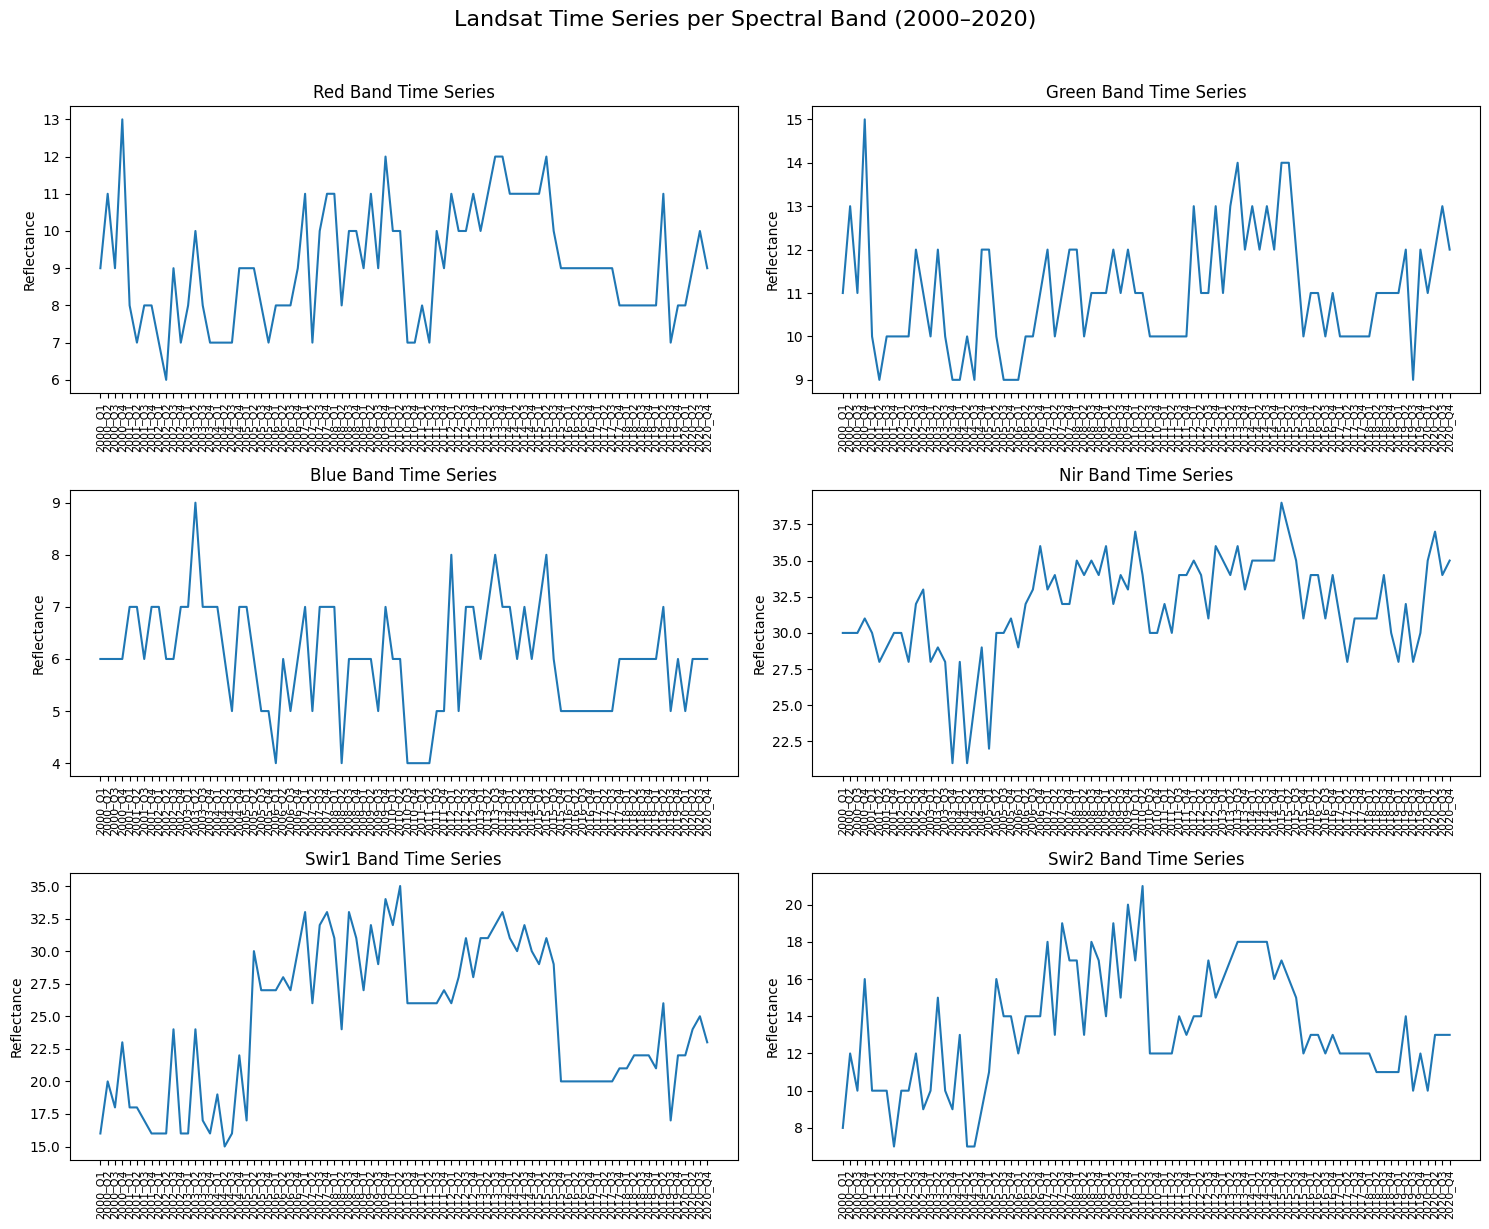

In [ ]:
bands: list[str] = ["red", "green", "blue", "nir", "swir1", "swir2"]

plt.figure(figsize=(15, 12))
for i, band in enumerate(iterable=bands):
    plt.subplot(3, 2, i + 1)
    plt.plot(time_labels, flattened[i], label=band)
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel(ylabel="Reflectance")
    plt.title(label=f"{band.capitalize()} Band Time Series")
    # plt.grid(True)
    plt.tight_layout()

plt.suptitle(t="Landsat Time Series per Spectral Band (2000–2020)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Prepare custom dataset loader

We have to sloightly update the Dataset to provide the relevant data in the
appropriate format.

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, data_dir, metadata, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.data_dir = data_dir
        self.metadata = metadata
        self.metadata = self.metadata.dropna(subset="speciesId").reset_index(drop=True)
        self.metadata["speciesId"] = self.metadata["speciesId"].astype(int)
        self.label_dict = (
            self.metadata.groupby("surveyId")["speciesId"].apply(list).to_dict()
        )

        self.metadata = self.metadata.drop_duplicates(subset="surveyId").reset_index(
            drop=True
        )

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]
        sample = torch.nan_to_num(
            torch.load(
                os.path.join(
                    self.data_dir,
                    f"GLC25-PA-{self.subset}-landsat-time-series_{survey_id}_cube.pt",
                ),
                weights_only=True,
            )
        )

        species_ids = self.label_dict.get(
            survey_id, []
        )  # Get list of species IDs for the survey ID
        label = torch.zeros(size=num_classes)  # Initialize label tensor
        for species_id in species_ids:
            # label_id = self.species_mapping[species_id]  # Get consecutive integer label
            label_id = species_id
            label[label_id] = (
                1  # Set the corresponding class index to 1 for each species
            )

        # Ensure the sample is in the correct format for the transform
        if isinstance(sample, torch.Tensor):
            sample = sample.permute(
                1, 2, 0
            )  # Change tensor shape from (C, H, W) to (H, W, C)
            sample = sample.numpy()  # Convert tensor to numpy array
            # print(sample.shape)

        if self.transform:
            sample = self.transform(sample)

        return sample, label, survey_id


class TestDataset(TrainDataset):
    def __init__(self, data_dir, metadata, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.data_dir = data_dir
        self.metadata = metadata

    def __getitem__(self, idx):
        survey_id = self.metadata.surveyId[idx]
        sample = torch.nan_to_num(
            torch.load(
                os.path.join(
                    self.data_dir,
                    f"GLC25-PA-{self.subset}-landsat_time_series_{survey_id}_cube.pt",
                ),
                weights_only=True,
            )
        )

        if isinstance(sample, torch.Tensor):
            sample = sample.permute(
                1, 2, 0
            )  # Change tensor shape from (C, H, W) to (H, W, C)
            sample = sample.numpy()

        if self.transform:
            sample = self.transform(sample)

        return sample, survey_id

### Load metadata and prepare data loaders

In [3]:
# Dataset and DataLoader
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

# Load Training metadata

"/kaggle/input/geolifeclef-2025/SateliteTimeSeries-Landsat/cubes/PA-train/"

train_data_path = (
    "/kaggle/input/geolifeclef-2025/SateliteTimeSeries-Landsat/cubes/PA-train/"
)
train_metadata_path = "/kaggle/input/geolifeclef-2025/GLC25_PA_metadata_train.csv"
train_metadata = pd.read_csv(train_metadata_path)
train_dataset = TrainDataset(
    train_data_path, train_metadata, subset="train", transform=transform
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# Load Test metadata
test_data_path = (
    "/kaggle/input/geolifeclef-2025/SateliteTimeSeries-Landsat/cubes/PA-test/"
)
test_metadata_path = "/kaggle/input/geolifeclef-2025/GLC25_PA_metadata_test.csv"
test_metadata = pd.read_csv(test_metadata_path)
test_dataset = TestDataset(
    test_data_path, test_metadata, subset="test", transform=transform
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/geolifeclef-2025/GLC25_PA_metadata_train.csv'

## Define and initialize the ModifiedResNet18 model

To utilize the landsat cubes, which have a shape of [6,4,21] (BANDs, QUARTERs,
and YEARs), some minor adjustments must be made to the vanilla ResNet-18. It's
important to note that this is just one method for ensuring compatibility with
the unusual tensor shape, and experimentation is encouraged.

In [ ]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet18, self).__init__()

        self.norm_input = nn.LayerNorm([6, 4, 21])
        self.resnet18 = models.resnet18(weights=None)
        # We have to modify the first convolutional layer to accept 4 channels instead of 3
        self.resnet18.conv1 = nn.Conv2d(
            6, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet18.maxpool = nn.Identity()
        self.ln = nn.LayerNorm(1000)
        self.fc1 = nn.Linear(1000, 2056)
        self.fc2 = nn.Linear(2056, num_classes)

    def forward(self, x):
        x = self.norm_input(x)
        x = self.resnet18(x)
        x = self.ln(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
def set_seed(seed):
    # Set seed for Python's built-in random number generator
    torch.manual_seed(seed)
    # Set seed for numpy
    np.random.seed(seed)
    # Set seed for CUDA if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(69)

In [ ]:
# Check if cuda is available
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")

num_classes = 11255  # Number of all unique classes within the PO and PA data.
model = ModifiedResNet18(num_classes).to(device)

DEVICE = CUDA


## Training Loop

Nothing special, just a standard Pytorch training loop.

In [ ]:
# Hyperparameters;
learning_rate = 0.0002
num_epochs = 20
positive_weigh_factor = 1.0
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25, verbose=True);

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
print(f"Training for {num_epochs} epochs started.")

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets, _) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        pos_weight = (
            targets * positive_weigh_factor
        )  # All positive weights are equal to 10
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 278 == 0:
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}"
            )

    scheduler.step()
    print("Scheduler:", scheduler.state_dict())

# Save the trained model
model.eval()
torch.save(model.state_dict(), "resnet18-with-landsat-cubes.pth")

Training for 20 epochs started.
Epoch 1/20, Batch 0/1391, Loss: 0.7073062658309937
Epoch 1/20, Batch 278/1391, Loss: 0.006236988585442305
Epoch 1/20, Batch 556/1391, Loss: 0.0056686000898480415
Epoch 1/20, Batch 834/1391, Loss: 0.005640304647386074
Epoch 1/20, Batch 1112/1391, Loss: 0.005799697246402502
Epoch 1/20, Batch 1390/1391, Loss: 0.004818603862076998
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 1, 'verbose': True, '_step_count': 2, '_get_lr_called_within_step': False, '_last_lr': [0.0001992114701314478]}
Epoch 2/20, Batch 0/1391, Loss: 0.005887552630156279
Epoch 2/20, Batch 278/1391, Loss: 0.005388566758483648
Epoch 2/20, Batch 556/1391, Loss: 0.005396657157689333
Epoch 2/20, Batch 834/1391, Loss: 0.004122779238969088
Epoch 2/20, Batch 1112/1391, Loss: 0.005589140113443136
Epoch 2/20, Batch 1390/1391, Loss: 0.004609483759850264
Scheduler: {'T_max': 25, 'eta_min': 0.0, 'base_lrs': [0.0002], 'last_epoch': 2, 'verbose': True, '_step_count': 3, '_get

## Test Loop

Again, nothing special, just a standard inference.

In [ ]:
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_k_indices = None
    for data, surveyID in tqdm.tqdm(test_loader, total=len(test_loader)):
        data = data.to(device)

        outputs = model(data)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        # Sellect top-25 values as predictions
        top_25 = np.argsort(-predictions, axis=1)[:, :25]
        if top_k_indices is None:
            top_k_indices = top_25
        else:
            top_k_indices = np.concatenate((top_k_indices, top_25), axis=0)

        surveys.extend(surveyID.cpu().numpy())

100%|██████████| 231/231 [00:33<00:00,  6.98it/s]


## Save prediction file! 🎉🥳🙌🤗

In [ ]:
data_concatenated = [" ".join(map(str, row)) for row in top_k_indices]

pd.DataFrame(
    {
        "surveyId": surveys,
        "predictions": data_concatenated,
    }
).to_csv("submission.csv", index=False)